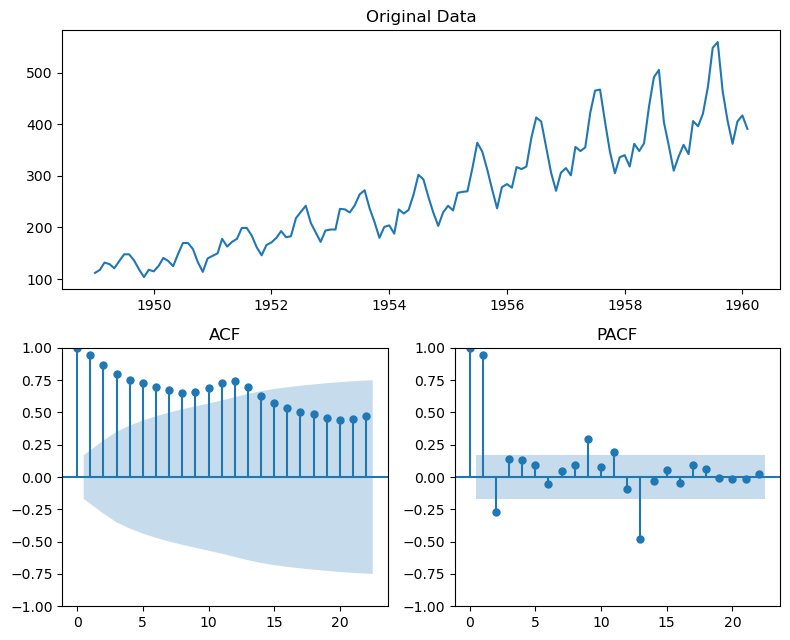

In [922]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np

test_with_artificial = False

num_predict_period = 10

def artificial_arima(p=np.array([]), d=0, q = np.array([]), f=lambda x:x, n = 100, m = 0):
    # generate synthetic data in order to validate our method for real data
    a  = np.random.normal(0,1,n)
    W = np.zeros(n)
    for t in range(n):   
        if t < len(p) or t < len(q):
            W[t] = 0 # maybe this can be done cleaner but whatever
        else:
            W[t] = - W[t-len(p):t] @ p[::-1] + a[t] + a[t-len(q):t] @ q[::-1] 
    
    for d_c in range(d):
        W = np.cumsum(W) 
        
    W += m    
        
    return f(W)
    
    


if test_with_artificial:
    n = 1000
    points = artificial_arima(
        p = np.array([.5, .6]),#np.array([0,0.1,0.2]),
        q = np.array([.3]),#np.array([0,0.1]),
        d = 1,
        f = lambda x:1.5**x,
        n = n,
        m = 0
    )
    dates = pd.date_range(start='1800-01-01', periods=n, freq='MS')
    
    # Create DataFrame with datetime index
    time_series_df = pd.DataFrame({'points': 1.7**points}, index=dates)
else:
    # Load the CSV file
    time_series_df = pd.read_csv('AirPassengers.csv', 
                            parse_dates=[0],  # Parse first column as dates
                            index_col=0)  # Set first column as index
    time_series_df['points'] = time_series_df.iloc[:, 0].replace(',', '', regex=True).astype(float)

time_series_df = time_series_df.asfreq('MS')
# split into training and test data
original_forecast_df = time_series_df[-num_predict_period:]
time_series_df = time_series_df[:-num_predict_period]
    
def plot_series(series, series_title, alpha = 0.05):
    """
    Plots the time series, ACF, and PACF with custom titles in a 2-column layout.

    Parameters:
    - series: The time series data to plot.
    - series_title: Title for the time series plot.
    """
    # Create a figure with custom layout using gridspec
    fig = plt.figure(figsize=(8, 6.5))
    gs = fig.add_gridspec(2, 2)   # 1 row, 2 columns

    # First column: Time Series plot (span both rows)
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(series)
    ax0.set_title(series_title)

    # Second column: ACF and PACF plots
    # ACF plot
    ax1 = fig.add_subplot(gs[1, 0])
    plot_acf(series, ax=ax1, alpha=alpha)
    ax1.set_title("ACF")

    # PACF plot
    ax2 = fig.add_subplot(gs[1, 1])  # Reuse the same axis for PACF
    plot_pacf(series, ax=ax2, alpha=alpha)
    ax2.set_title("PACF")

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    
plot_series(time_series_df['points'], "Original Data")


Use a full automatic test to which we can compare our results to

In [923]:
if False:
    import pmdarima as pm
    
    # Automatically fit the best ARIMA/SARIMA model
    model = pm.auto_arima(
        time_series_df['points'],
        seasonal=False,      # Enable seasonal differencing if necessary
        stepwise=True,      # Use stepwise algorithm for faster computation
        trace=True,         # Show the fitting process details
        max_p=3,              # Set maximum p value to control AR component
        max_q=3,              # Set maximum q value to control MA component
        max_d=1,              # Set maximum differencing order
        max_P=1,              # Set maximum seasonal AR order
        max_Q=1,              # Set maximum seasonal MA order
        max_D=1,
        max_order = 10
    )
    
    
    # Summary of the best model found
    print(model.summary())
    
    # Predict future values (e.g., next 12 periods)
    forecast = model.predict(n_periods=12)


Test stationarity, Augmented Dickey-Fuller unit root test.

In [924]:
#Check stationarity
# alternative hypothesis is stationarity 
st.adfuller(time_series_df['points'])


(0.81851581892665,
 0.9919292447083797,
 13,
 120,
 {'1%': -3.486055829282407,
  '5%': -2.8859430324074076,
  '10%': -2.5797850694444446},
 902.494902374049)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

used lambda:  0.16194288973968288


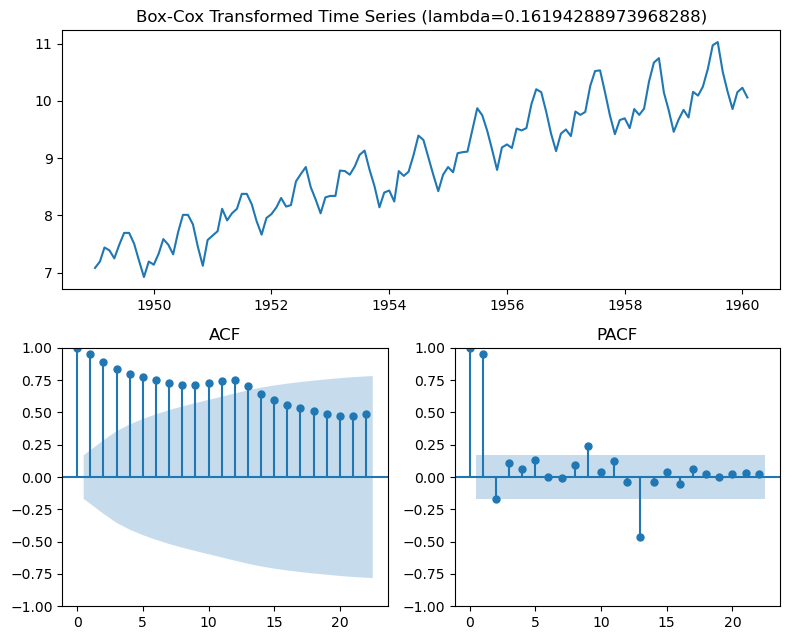

In [925]:
from scipy import stats
use_trafo = True
if use_trafo:
    # Apply Box-Cox transformation and estimate lambda
    lmbda = None
    if lmbda is None:
        transformed_prices, lmbda = stats.boxcox(time_series_df["points"])
    else:
        transformed_prices = stats.boxcox(time_series_df["points"], lmbda =lmbda)
    
    # Store the transformed values back into the DataFrame
    time_series_df['T_points'] = transformed_prices
    print("used lambda: ", lmbda)
else:
    lmbda = None
    time_series_df['T_points'] = time_series_df['points']
plot_series(time_series_df['T_points'], f"Box-Cox Transformed Time Series (lambda={lmbda})")
    


Differentiate and see when stationarity tests become positive

In [926]:
alpha = 0.005

        

# Assuming 'time_series_df' is your DataFrame and 'Prices' is the column
current_series = time_series_df['T_points'] 
differencing_count = 0

# Function to apply ADF test and get p-value
def get_adf_p_value(series):
    adf_result = st.adfuller(series.dropna())
    return adf_result[1]  # Return p-value from ADF test

# Keep iterating until the series is stationary or we reach the max differencing
while get_adf_p_value(current_series) >= alpha:
    differencing_count += 1
    # Apply first-order differencing
    current_series = current_series.diff() # drop NaNs that come to existance by doing diff operation

    # Print progress with the p-value after differencing
    print(f"After {differencing_count} differencing(s), the ADF p-value is: {get_adf_p_value(current_series)}")

# Add the differenced series to the DataFrame
time_series_df['diff_points'] = current_series.copy()    

# Check if series is stationary after differencing
if get_adf_p_value(current_series) < alpha:
    print(f"Series is stationary after {differencing_count} differencings.")
    print("")
else:
    print("Max differencings reached without achieving stationarity.")





After 1 differencing(s), the ADF p-value is: 0.01696346663053899
After 2 differencing(s), the ADF p-value is: 7.983259073266935e-12
Series is stationary after 2 differencings.



Plot the new time series and acf and pcf

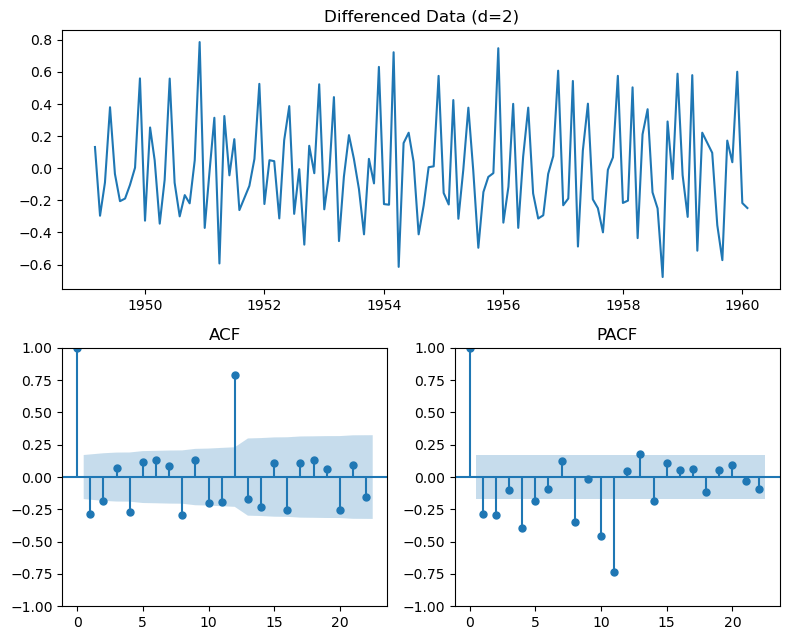

In [927]:
data = time_series_df['diff_points'].dropna() #dropnans from differentiating

plot_series(data, f"Differenced Data (d={differencing_count})", alpha = 0.05)


Print out all lags that are sginificantly non zero

In [928]:
data = time_series_df['diff_points'].dropna()

def print_significant_lags(data, alpha=0.05, nlags=40):
    """
    Calculate and print all significantly non-zero lags using ACF.
    
    Parameters:
    -----------
    data : array-like
        The time series data
    alpha : float, default=0.05
        Significance level for the confidence intervals
    nlags : int, default=40
        Number of lags to calculate
    
    Returns:
    --------
    tuple
        - List of significant lag indices
        - ACF values for significant lags
        - Confidence intervals
    """
    # Calculate ACF with confidence intervals
    acf_values, acf_confint = st.acf(data, alpha=alpha, fft=True, nlags=nlags, adjusted=True)
    pacf_values, pacf_confint = st.pacf(data, alpha=alpha, nlags=nlags)
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    acf_significant_lags = []
    acf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | ACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(acf_values)):
        lower_ci = acf_confint[lag][0]
        upper_ci = acf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            acf_significant_lags.append(lag)
            acf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {acf_values[lag]:9.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    pacf_significant_lags = []
    pacf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | PACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(pacf_values)):
        lower_ci = pacf_confint[lag][0]
        upper_ci = pacf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            pacf_significant_lags.append(lag)
            pacf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {pacf_values[lag]:10.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    if not acf_significant_lags and not pacf_significant_lags:
        print("No significant lags found.")
   
    return (acf_significant_lags, acf_significant_values, acf_confint), (pacf_significant_lags, pacf_significant_values, pacf_confint)
sig = print_significant_lags(data)


Significant lags at 5.0% significance level:
----------------------------------------
Lag | ACF Value | Confidence Interval
----------------------------------------
  0 |     1.000 | [ 1.000,  1.000]
  1 |    -0.291 | [-0.461, -0.120]
  2 |    -0.187 | [-0.371, -0.002]
  4 |    -0.276 | [-0.466, -0.085]
  8 |    -0.313 | [-0.521, -0.106]
 12 |     0.867 | [ 0.632,  1.102]
 24 |     0.810 | [ 0.459,  1.162]
 36 |     0.818 | [ 0.392,  1.244]

Significant lags at 5.0% significance level:
----------------------------------------
Lag | PACF Value | Confidence Interval
----------------------------------------
  0 |      1.000 | [ 1.000,  1.000]
  1 |     -0.291 | [-0.461, -0.120]
  2 |     -0.296 | [-0.467, -0.126]
  4 |     -0.411 | [-0.582, -0.241]
  5 |     -0.203 | [-0.374, -0.032]
  8 |     -0.382 | [-0.552, -0.211]
 10 |     -0.536 | [-0.707, -0.366]
 11 |     -0.983 | [-1.154, -0.813]
 12 |     -8.519 | [-8.690, -8.349]
 13 |      1.071 | [ 0.901,  1.242]
 14 |      0.244 | [ 0.074,

From the significant acf and pacf lags and the acf and pacf graphs we can
propose these models: (TODO adjat models to real life data and add explanations)
ARIMA(5,1,0)
ARIMA(0,1,5)
ARIMA(5,1,5)




## Estimate Parameters


ARIMA(0,1,0):
AIC: 21.28
BIC: 24.17

ARIMA(1,1,0):
AIC: 17.23
BIC: 23.01

ARIMA(0,1,1):
AIC: 15.05
BIC: 20.83


/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARIMA(14,1,0):
AIC: -200.57
BIC: -157.21


/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA(14,1,6):
AIC: -197.01
BIC: -136.31


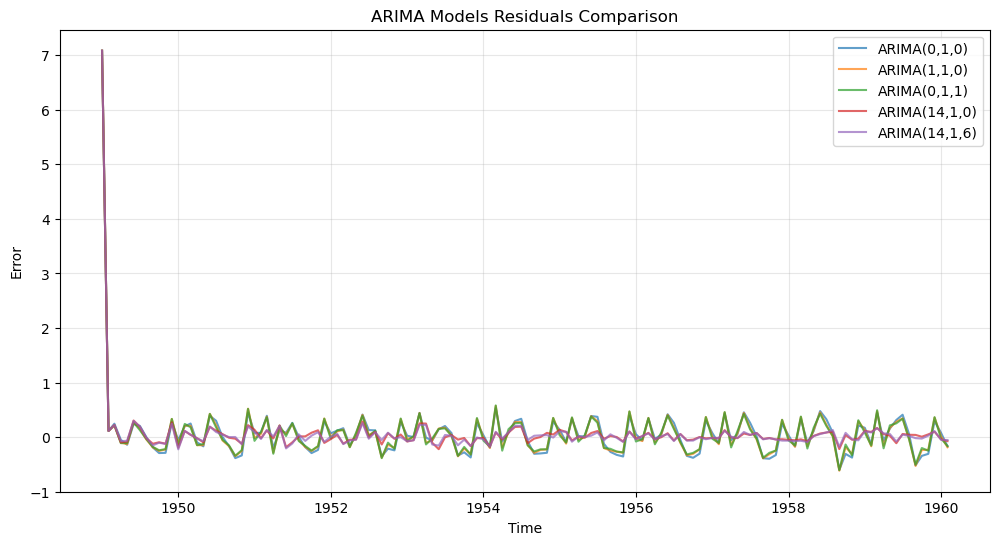

In [929]:
from statsmodels.tsa.arima.model import ARIMA

data = time_series_df['T_points'].dropna()

suggested_models = np.array([
    [0,1,0],
    [1,1,0],
    [0,1,1],
    [14,1,0],
    [14,1,6]
])
results = []
error_dfs = []  
fitted_models = []
for p, d, q in suggested_models:
    model = ARIMA(data, order=(p, d, q))
    fitted = model.fit()
    
    results.append({
        'order': f"ARIMA({p},{d},{q})",
        'aic': fitted.aic,
        'bic': fitted.bic,
        'p': p,
        'd': d,
        'q': q
    })
    
    print(f"\nARIMA({p},{d},{q}):")
    print(f"AIC: {fitted.aic:.2f}")
    print(f"BIC: {fitted.bic:.2f}")
    
    
    # Get residuals and add to list
    residuals = pd.DataFrame(fitted.resid)
    residuals.columns = [f'ARIMA({p},{d},{q})']
    error_dfs.append(residuals)
    
    
    # Store the fitted model object
    fitted_models.append(fitted)
    
    
# Combine all residuals into one DataFrame
all_errors = pd.concat(error_dfs, axis=1)


# Create a DataFrame for the fitted models
fitted_models_df = pd.DataFrame({
    'model_order': [f"ARIMA({p},{d},{q})" for p, d, q in suggested_models],
    'fitted_model': fitted_models
})

# Plot using matplotlib
plt.figure(figsize=(12, 6))
for column in all_errors.columns:
    plt.plot(all_errors.index, all_errors[column], label=column, alpha=0.7)
plt.legend()
plt.title('ARIMA Models Residuals Comparison')
plt.xlabel('Time')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)
plt.show()

#plot_series(all_errors['ARIMA(1,1,1)'], "timeseries of residuals")


        

## Verify 8 supuestos

#### Tests on residuals


In [930]:

import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro, jarque_bera, ttest_1samp
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
import statsmodels.stats.weightstats as smw

# Example residuals DataFrame (assuming you've created it as `all_errors` before)
# all_errors contains residuals for each ARIMA model
# Iterate over each model's residuals and perform tests

# Initialize a list to store the test results
residuals_tests = []

data = time_series_df['T_points'].dropna()

# Function to test residuals
def test_residuals(residuals, model_name, alpha = 0.05):
    results = {}
    # 1. Test if 
    # Perform a t-test to check if the mean is significantly different from 0
    p_value = ttest_1samp(residuals, 0).pvalue
    results['mean_close_to_0'] = p_value > alpha  # Within tolerance
    print(f"{model_name}: Mean of residuals = {np.mean(residuals):.4f}, p_value = {p_value:.4f}")
    

    # 2. Check for constant variance (Homoscedasticity) using Breusch-Pagan test
    _, pvalue, _, _ = het_breuschpagan(residuals, sm.add_constant(np.arange(len(residuals))))
    results['constant_variance'] = pvalue > alpha
    print(f"{model_name}: Homoscedasticity (Breusch-Pagan p-value) = {pvalue:.4f}")

    # 3. Normality Tests
    # Shapiro-Wilk test
    _, shapiro_pvalue = shapiro(residuals)
    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(residuals)
    results['normal_distribution'] = shapiro_pvalue > alpha and jb_pvalue > alpha
    print(f"{model_name}: Normality (Shapiro-Wilk p-value) = {shapiro_pvalue:.4f}")
    print(f"{model_name}: Normality (Jarque-Bera p-value) = {jb_pvalue:.4f}")

    # 4. Independence Test using Ljung-Box test
    # Setting a maximum lag of 10 (adjust as necessary)
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    pvalue_ljungbox = lb_test['lb_pvalue'].values[0]
    results['independent_errors'] = pvalue_ljungbox > alpha
    print(f"{model_name}: Independence (Ljung-Box p-value) = {pvalue_ljungbox:.4f}")

    # Store results in the residuals_tests list
    residuals_tests.append({'model': model_name, 'results': results})
    if False:
        # Additional Plots
        plt.figure(figsize=(10, 6))
    
        # Histogram and Q-Q plot
        plt.subplot(1, 2, 1)
        plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'{model_name} Residuals Histogram')
        plt.axvline(x=0, color='red', linestyle='--', label='Mean = 0')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        sm.qqplot(residuals, line='s')
        plt.title(f'{model_name} Q-Q Plot')
    
        plt.tight_layout()
        plt.show()
    
    print("-" * 40)
    
    
# Iterate over each column in all_errors DataFrame
for column in all_errors.columns:
    print("column", column)
    residuals = all_errors[column].dropna()  # Drop NaNs if they exist
    test_residuals(residuals, column)

# Print summary of results
print("\nSummary of Residuals Assumptions Check:")
for result in residuals_tests:
    model_name = result['model']
    tests = result['results']
    print(f"{model_name}:")
    print(f"  Mean close to 0: {'Pass' if tests['mean_close_to_0'] else 'Fail'}")
    print(f"  Constant Variance: {'Pass' if tests['constant_variance'] else 'Fail'}")
    print(f"  Normal Distribution: {'Pass' if tests['normal_distribution'] else 'Fail'}")
    print(f"  Independent Errors: {'Pass' if tests['independent_errors'] else 'Fail'}")
    print("-" * 40)
#

column ARIMA(0,1,0)
ARIMA(0,1,0): Mean of residuals = 0.0751, p_value = 0.1921
ARIMA(0,1,0): Homoscedasticity (Breusch-Pagan p-value) = 0.0916
ARIMA(0,1,0): Normality (Shapiro-Wilk p-value) = 0.0000
ARIMA(0,1,0): Normality (Jarque-Bera p-value) = 0.0000
ARIMA(0,1,0): Independence (Ljung-Box p-value) = 0.9796
----------------------------------------
column ARIMA(1,1,0)
ARIMA(1,1,0): Mean of residuals = 0.0701, p_value = 0.2216
ARIMA(1,1,0): Homoscedasticity (Breusch-Pagan p-value) = 0.0905
ARIMA(1,1,0): Normality (Shapiro-Wilk p-value) = 0.0000
ARIMA(1,1,0): Normality (Jarque-Bera p-value) = 0.0000
ARIMA(1,1,0): Independence (Ljung-Box p-value) = 0.9933
----------------------------------------
column ARIMA(0,1,1)
ARIMA(0,1,1): Mean of residuals = 0.0699, p_value = 0.2226
ARIMA(0,1,1): Homoscedasticity (Breusch-Pagan p-value) = 0.0903
ARIMA(0,1,1): Normality (Shapiro-Wilk p-value) = 0.0000
ARIMA(0,1,1): Normality (Jarque-Bera p-value) = 0.0000
ARIMA(0,1,1): Independence (Ljung-Box p-valu

### Supuesto 5: Modelo Parsimonioso

In [931]:
# Create lists to store models that pass and fail the test
models_pass = []
models_fail = []

# Iterate over each fitted model in the DataFrame
for index, row in fitted_models_df.iterrows():
    # Get the model order and fitted model object
    model_order = row['model_order']
    fitted_model = row['fitted_model']
    
    # Get the confidence intervals for the parameters
    conf_intervals = fitted_model.conf_int()
    
    print(f"\nParameters for {model_order}:")
    print(parameters)
    
    print(f"\nConfidence Intervals for {model_order}:")
    print(conf_intervals)
    print("-" * 50)
    
    # Check if all confidence intervals do not contain zero
    intervals_do_not_contain_zero = (conf_intervals[0] > 0) | (conf_intervals[1] < 0)
    
    if intervals_do_not_contain_zero.all():
        # If all parameters' confidence intervals do not contain zero
        models_pass.append(model_order)
    else:
        # If any parameter's confidence interval contains zero
        models_fail.append(model_order)

# Print the results
print("\nSummary of ARIMA Model Significance Test Based on Confidence Intervals:")
print("===================================================")
print("Models that Passed (Confidence Intervals do NOT contain zero):")
print(models_pass)
print("\nModels that Failed (Confidence Intervals contain zero):")
print(models_fail)



Parameters for ARIMA(0,1,0):
ar.L1    -0.159288
ma.L1     0.531964
sigma2    0.965557
dtype: float64

Confidence Intervals for ARIMA(0,1,0):
              0         1
sigma2  0.04509  0.090276
--------------------------------------------------

Parameters for ARIMA(1,1,0):
ar.L1    -0.159288
ma.L1     0.531964
sigma2    0.965557
dtype: float64

Confidence Intervals for ARIMA(1,1,0):
               0         1
ar.L1   0.019798  0.401332
sigma2  0.044046  0.085252
--------------------------------------------------

Parameters for ARIMA(0,1,1):
ar.L1    -0.159288
ma.L1     0.531964
sigma2    0.965557
dtype: float64

Confidence Intervals for ARIMA(0,1,1):
               0         1
ma.L1   0.074443  0.494989
sigma2  0.043930  0.083224
--------------------------------------------------

Parameters for ARIMA(14,1,0):
ar.L1    -0.159288
ma.L1     0.531964
sigma2    0.965557
dtype: float64

Confidence Intervals for ARIMA(14,1,0):
               0         1
ar.L1  -0.410505 -0.097890
ar.L2  -0

### Supuesto 6, modelos crean seria estationario y invertible

In [932]:
# Create lists to store models that pass and fail the stationary test
admisible_models = []
non_admisible_models = []

# Iterate over each fitted model in the DataFrame
for index, row in fitted_models_df.iterrows():
    # Get the model order and fitted model object
    model_order = row['model_order']
    fitted_model = row['fitted_model']
    
    # Get the MA parameters from the model's parameters
    ma_params = [param for param in fitted_model.params.index if 'ma.L' in param]
        
    # Extract the MA parameter values
    ma_coefficients = [fitted_model.params[param] for param in ma_params]
    
    # Compute the roots of the MA polynomial: 1 - p1*x - p2*x^2 - ...
    ma_roots = np.roots(([1] + [-coeff for coeff in ma_coefficients])[::-1])  # Coefficients are negated
    
    # Get the AR parameters from the model's parameters
    ar_params = [param for param in fitted_model.params.index if 'ar.L' in param]
        
    # Extract the MA parameter values
    ar_coefficients = [fitted_model.params[param] for param in ar_params]
    
    # Compute the roots of the MA polynomial: 1 - p1*x - p2*x^2 - ...
    ar_roots = np.roots(([1] + [-coeff for coeff in ar_coefficients])[::-1])  # Coefficients are negated
    
    
    # Check if all roots are outside the unit circle (i.e., absolute value > 1)
    if np.all(np.abs(ma_roots) > 1) and np.all(np.abs(ar_roots) > 1):
        admisible_models.append(model_order)
    else:
        non_admisible_models.append(model_order)

# Print the results
print("\nSummary of Admisibility Test Based on MA and AR Polynomial Roots:")
print("===================================================")
print("Models that Passed (Admisible Models with Roots Outside the Unit Circle):")
print(admisible_models)
print("\nModels that Failed (Non-Admisible Models with Roots Inside or on the Unit Circle):")
print(non_admisible_models)


Summary of Admisibility Test Based on MA and AR Polynomial Roots:
Models that Passed (Admisible Models with Roots Outside the Unit Circle):
['ARIMA(0,1,0)', 'ARIMA(1,1,0)', 'ARIMA(0,1,1)', 'ARIMA(14,1,0)', 'ARIMA(14,1,6)']

Models that Failed (Non-Admisible Models with Roots Inside or on the Unit Circle):
[]


### TODO supuestos 7 y 8

In [933]:
# todo

### Supuesto 7, 

check if correlations between estimated parameters are small



In [934]:
from statsmodels.stats.moment_helpers import cov2corr

# Loop over each ARIMA model in the fitted_models_df DataFrame
for idx, row in fitted_models_df.iterrows():
    model_name = row['model_order']
    fitted_model = row['fitted_model']
    
    # Extract the variance-covariance matrix of parameters
    cov_matrix = fitted_model.cov_params()
    correlation_matrix = cov2corr(cov_matrix)
    # Create a DataFrame for easier readability
    correlation_df = pd.DataFrame(correlation_matrix, 
                                  index=fitted_model.param_names, 
                                  columns=fitted_model.param_names)
    
    # Display the correlation matrix
    print(f"\nCorrelation Matrix of Parameters for {model_name}:")
    print(correlation_df)



Correlation Matrix of Parameters for ARIMA(0,1,0):
        sigma2
sigma2     1.0

Correlation Matrix of Parameters for ARIMA(1,1,0):
           ar.L1    sigma2
ar.L1   1.000000  0.260218
sigma2  0.260218  1.000000

Correlation Matrix of Parameters for ARIMA(0,1,1):
           ma.L1    sigma2
ma.L1   1.000000  0.082552
sigma2  0.082552  1.000000

Correlation Matrix of Parameters for ARIMA(14,1,0):
           ar.L1     ar.L2     ar.L3     ar.L4     ar.L5     ar.L6     ar.L7  \
ar.L1   1.000000  0.336428  0.033385 -0.285463  0.101430 -0.257297 -0.039118   
ar.L2   0.336428  1.000000 -0.198609 -0.067547 -0.172430  0.108046 -0.171271   
ar.L3   0.033385 -0.198609  1.000000  0.183137  0.418087  0.102825  0.699325   
ar.L4  -0.285463 -0.067547  0.183137  1.000000  0.198260  0.539840  0.427252   
ar.L5   0.101430 -0.172430  0.418087  0.198260  1.000000  0.132938  0.371972   
ar.L6  -0.257297  0.108046  0.102825  0.539840  0.132938  1.000000  0.196513   
ar.L7  -0.039118 -0.171271  0.699325  0

### Supuesto 8

## Calculate the Forecast and confidence intervalls

In [935]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import special

# Define the number of periods to forecast and the confidence level
confidence_level = 0.75  # Confidence level (e.g., 0.95 for 95%)

# List of models to use
models_to_forecast = ['ARIMA(2,1,1)', 'ARIMA(0,1,0)']

def forecast(data, models_to_forecast, start, end, lmbda=None):
    # if lmbda is not None, Box-Cox transformation was applied, and we need to handle inverse transformation
    
    forecast_results = {}
    
    # Retrieve the last portion of the original data
    data_to_plot = data[start-(end-start)*2:]
    
    # Create a date range for the forecasted periods
    if start < len(data):
        start_date = data.index[start]

        # Create the forecast index
        forecast_index = pd.date_range(start=start_date, periods=np.abs(end-start)+1, freq='MS')
    else:
        last_date = data.index[-1]
        overlap = start - len(data) +1
        forecast_index = pd.date_range(start=last_date, periods=np.abs(end-start)+overlap+1, freq='MS')[overlap:]
    
    
    # Iterate over each model in the DataFrame and forecast
    for model_name in models_to_forecast:
        # Retrieve the fitted model from the DataFrame
        fitted_model = fitted_models_df.loc[fitted_models_df['model_order'] == model_name, 'fitted_model'].iloc[0]
        
        # Forecast the next n periods with the specified confidence level
        #forecast = fitted_model.get_forecast(steps=n_periods)
        forecast = fitted_model.get_prediction(start=start, end=end)
        # Get the predicted mean and confidence intervals
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int(alpha=1 - confidence_level)  # Adjust alpha for the confidence interval
        
        # If lmbda is provided, apply inverse Box-Cox transformation to return to original scale
        if lmbda is not None:
            var = np.var(fitted_model.resid)
            if lmbda == 0:
                correction_factor = np.exp(var/2)
            else:
                correction_factor = (.5 + np.sqrt(1-2*lmbda*(lmbda-1)*(1+lmbda * forecast_mean)**(-1)*var)/2)**(1/lmbda) 
            
            forecast_mean = special.inv_boxcox(forecast_mean, lmbda) * correction_factor
            
            forecast_ci['lower T_points'] =forecast_ci['lower T_points'].apply(lambda x: special.inv_boxcox(x, lmbda)) * correction_factor
            forecast_ci['upper T_points'] = forecast_ci['upper T_points'].apply(lambda x: special.inv_boxcox(x, lmbda)) * correction_factor
            
            
        # Store the forecast results for plotting
        forecast_results[model_name] = {
            'forecast_mean': forecast_mean,
            'forecast_ci': forecast_ci
        }
        
        # Print the forecasted values and confidence intervals
        print(f"\nForecast for {model_name} for the next {end-start} periods with {confidence_level*100:.1f}% Confidence Interval:")
        print(forecast_mean)
        print("\nConfidence Interval:")
        print(forecast_ci)
        
        # Loop over the forecast index and compare with the original data
        print("\nComparison of Forecasts with Original Data:")
        print("Date\t\tForecast\tOriginal Data\tDifference")
        
        for date, forecast_value in zip(forecast_index, forecast_mean):
            # Check if the date exists in the original data
            if date in data.index:
                original_value = data.loc[date]
                difference = original_value - forecast_value
                print(f"{date.strftime('%Y-%m-%d')}\t{forecast_value:.2f}\t\t{original_value:.2f}\t\t\t{difference:.2f}")
            else:
                print(f"{date.strftime('%Y-%m-%d')}\t{forecast_value:.2f}\t\tData Not Available")
        

        
        print("-" * 40)
        
    # Plot the forecasts from both models
    plt.figure(figsize=(10, 6))
    
    # Plot the last portion of the original data
    plt.plot(data_to_plot.index, data_to_plot, label='Original Data', color='blue')
    
    
    
    # Plot forecasts and confidence intervals for each model
    colors = {'ARIMA(2,1,1)': 'green', 'ARIMA(0,1,0)': 'orange'}
    
    for model_name, result in forecast_results.items():
        forecast_mean = result['forecast_mean']
        forecast_ci = result['forecast_ci']
        
        # Plot forecasted values
        plt.plot(forecast_index, forecast_mean, label=f'Forecast - {model_name}', color=colors[model_name], marker='o')
        
        # Plot confidence intervals
        plt.fill_between(forecast_index,
                         forecast_ci.iloc[:, 0],
                         forecast_ci.iloc[:, 1],
                         color=colors[model_name], alpha=0.2)
    
    
    # Finalize the plot
    plt.title(f'Forecast Comparison for ARIMA(1,1,1) and ARIMA(1,1,0) with {confidence_level*100:.1f}% Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



### Predict in sample values

In [936]:
num_predictions = 10
end = len(time_series_df['points']) -1
start = end-(num_predictions-1)
forecast(time_series_df['points'], models_to_forecast, start=start, end=end, lmbda=lmbda)


IndexError: single positional indexer is out-of-bounds

### Predict out of sample values


Forecast for ARIMA(2,1,1) for the next 9 periods with 75.0% Confidence Interval:
2024-02-01    4916.292636
2024-03-01    4907.056215
2024-04-01    4913.873901
2024-05-01    4908.869261
2024-06-01    4912.541170
2024-07-01    4909.846514
2024-08-01    4911.823687
2024-09-01    4910.372788
2024-10-01    4911.437401
2024-11-01    4910.656179
Freq: MS, Name: predicted_mean, dtype: float64

Confidence Interval:
            lower T_points  upper T_points
2024-02-01     4700.490334     5141.312538
2024-03-01     4599.236375     5234.016629
2024-04-01     4542.257567     5313.709209
2024-05-01     4480.892068     5374.752735
2024-06-01     4437.310124     5434.934655
2024-07-01     4391.180052     5485.240071
2024-08-01     4354.226443     5535.497227
2024-09-01     4316.427887     5579.899142
2024-10-01     4283.846844     5624.007974
2024-11-01     4251.327922     5664.441959

Comparison of Forecasts with Original Data:
Date		Forecast	Original Data	Difference
2024-02-01	4916.29		Data Not Av

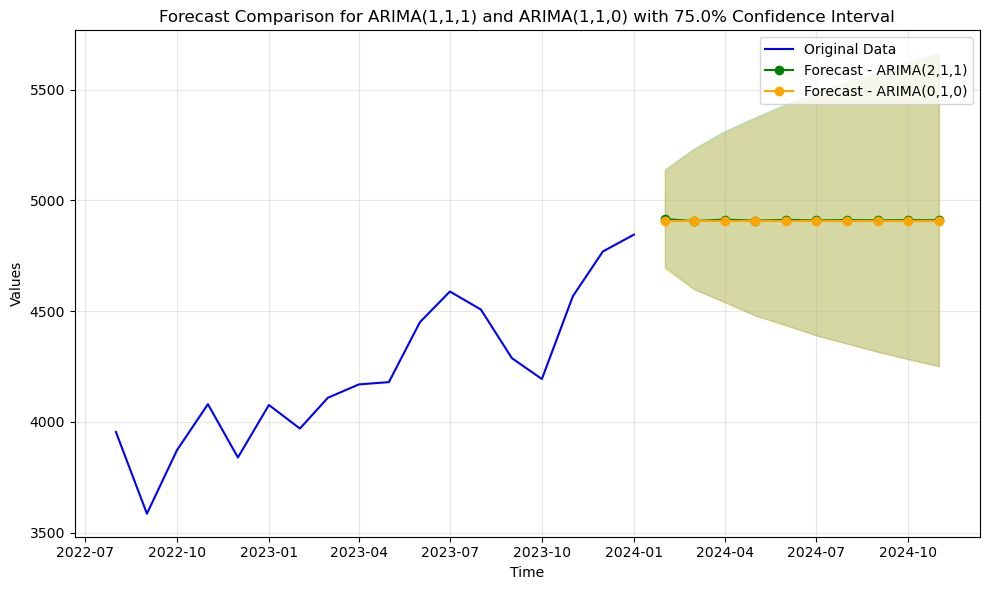

In [921]:
num_predictions = 10
start= len(time_series_df['points'])
end = start+num_predictions-1

forecast(time_series_df['points'], models_to_forecast, start=start, end=end, lmbda=lmbda)